In [23]:
%pip install tensorflow matplotlib Pillow scipy scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import sys
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)

Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
TensorFlow version: 2.19.0


 DATA AUGMENTATION

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '../Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

Found 1860 images belonging to 5 classes.
Found 467 images belonging to 5 classes.


LOAD BASE MODEL  RESNET50

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

FINE-TUNE 120 LAYER CUỐI

In [6]:
for layer in base_model.layers[:-120]:
    layer.trainable = False
for layer in base_model.layers[-120:]:
    layer.trainable = True

ADD HEAD

In [7]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 23,271,685 (88.77 MB)

 Non-trainable params: 874,112 (3.33 MB)

COMPILE MODEL

In [6]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

CALL BACK

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

TRAIN

In [8]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.2137 - loss: 1.7666 - val_accuracy: 0.2141 - val_loss: 1.6162 - learning_rate: 1.0000e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.3997 - loss: 1.3567 - val_accuracy: 0.1884 - val_loss: 1.6417 - learning_rate: 1.0000e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.6321 - loss: 0.8988 - val_accuracy: 0.2784 - val_loss: 1.8870 - learning_rate: 1.0000e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.8203 - loss: 0.5265 - val_accuracy: 0.2141 - val_loss: 5.8692 - learning_rate: 1.0000e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.9257 - loss: 0.2440 - val_accuracy: 0.4668 - val_loss: 1.8797 - learning_rate: 2.0000e-05
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.9417 - loss: 0.2008 - val_accuracy: 0.4518 - val_loss: 3.7207 - learning_rate: 2.0000e-05
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.9586 

EVALUATE

In [9]:
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - loss: 2.6826e-04
Test Loss: 0.00020895908528473228
Test Accuracy: 1.0


SAVE MODEL

In [17]:
model.save('../model/resnet50_finetune.h5')
print("Model saved as ./resnet50_finetune.h5")


Model saved as ./resnet50_finetune.h5


CONFUSION MATRIX

15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


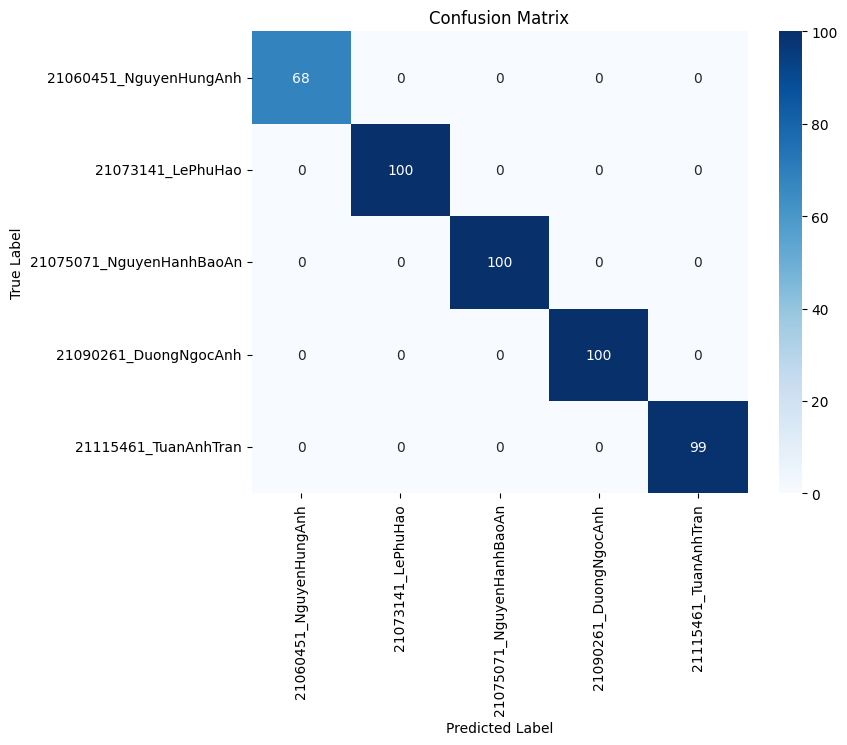

                          precision    recall  f1-score   support

  21060451_NguyenHungAnh       1.00      1.00      1.00        68
       21073141_LePhuHao       1.00      1.00      1.00       100
21075071_NguyenHanhBaoAn       1.00      1.00      1.00       100
   21090261_DuongNgocAnh       1.00      1.00      1.00       100
    21115461_TuanAnhTran       1.00      1.00      1.00        99

                accuracy                           1.00       467
               macro avg       1.00      1.00      1.00       467
            weighted avg       1.00      1.00      1.00       467



In [15]:
true_labels = test_generator.classes
pred_probs = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(true_labels, pred_labels)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

PLOT ACCURACY & LOSS

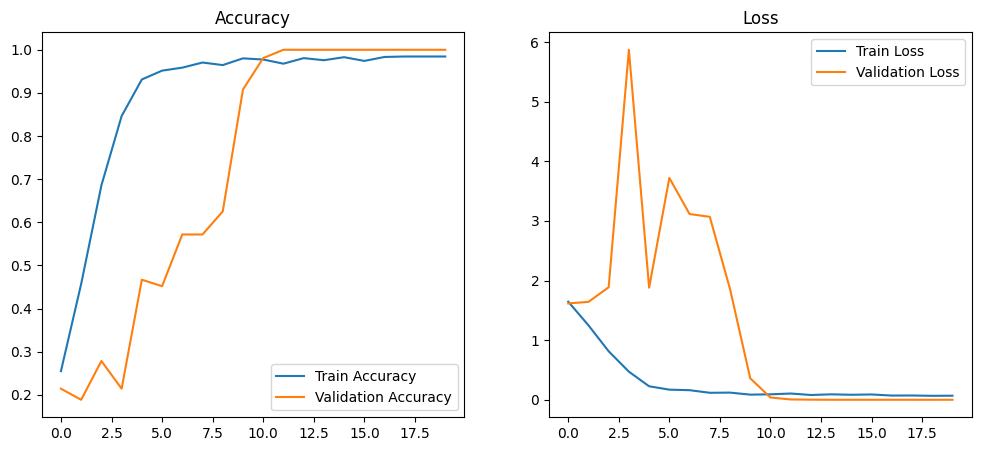

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

PREDICT TEST

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: 21090261_DuongNgocAnh


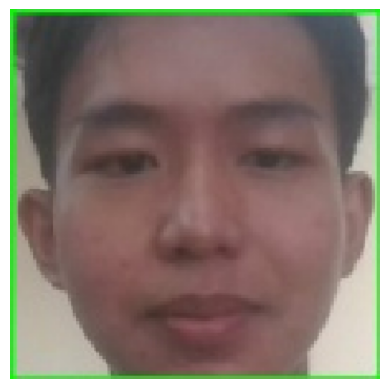

In [21]:
model = load_model('../model/resnet50_finetune.h5')

img_path = '../Test/21090261_DuongNgocAnh/43.jpg'  # ảnh test
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred)

class_labels = list(train_generator.class_indices.keys())
print("Predicted:", class_labels[predicted_class])
plt.imshow(img)
plt.axis('off')
plt.show()